In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Cleaning

In [2]:
sales = pd.read_parquet('sale_sample_18-21.parquet')
township_codes = gpd.read_file('townships.geojson')
char_sample = pd.read_csv('char_sample.csv', dtype={'class': str}) # also has 'EX' in column
geo_info = pd.read_csv('parcels_geoinfo.csv')

sales.year = sales.year.astype(int)
sales.pin = sales.pin.astype(int)
#sales.township = sales.township_code.astype(int)
#townships.township = townships.township.astype(int)
geo_info['class'] = geo_info['class'].astype(str)
geo_info.drop(['year'], axis=1,  inplace=True)
sales['class'] = sales['class'].astype(str)
sales.township_code = sales.township_code.astype(int)
sales = pd.merge(sales, geo_info, on=['pin', 'class'], how='outer')
sales = pd.merge(sales, char_sample, on=['pin', 'year', 'class'])
sales = sales[sales['is_multisale'] != 1]
sales = sales[sales['num_parcels_sale'] == 1] # STOP GAP
sales.rename(columns = {'township_code_x': 'township_code'}, inplace=True)


# Variance - Outlier Detection

Just check number of deivations away from mean grouped by township_code.

Problems:

Would like to vary by geography, but how to join new geographies to table to do that? What is value in common? With spatial dataset could see what PINS in what unit, but we have no lat/long for data.


In [3]:
sales

,pin,year,township_code,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,township_code_y,census_tract_geoid,lat,lon,sqft,year_built
0,2092050370000,2019.0,29.0,295,2019-05-01 00:00:00+00:00,201000.0,5.303196,96812985.0,1915417094,01,...,0,0.0,0.0,0.0,29.0,NaN,NaN,NaN,1155.0,1985.0
2,10201120410000,2018.0,24.0,206,2018-07-01 00:00:00+00:00,540000.0,5.732394,97373057.0,1822817046,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2256.0,1947.0
3,16183030040000,2022.0,27.0,203,2022-02-11 00:00:00+00:00,595000.0,5.774517,7321053.0,2206001050,01,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1787.0,1918.0
4,10272320440000,2020.0,24.0,203,2020-04-01 00:00:00+00:00,285000.0,5.454845,96592558.0,2019607192,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1332.0,1953.0
6,15011010390000,2020.0,33.0,234,2020-12-29 00:00:00+00:00,480000.0,5.681241,7127160.0,2102855154,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2079.0,1888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360972,7294030160000,2021.0,35.0,278,2021-08-30 00:00:00+00:00,220000.0,5.342423,7249327.0,2126546039,01,...,0,0.0,0.0,0.0,35.0,1.703180e+10,42.010148,-88.116944,2330.0,1966.0
360973,7262000211004,2018.0,35.0,299,2018-04-01 00:00:00+00:00,173000.0,5.238046,97001692.0,1812729171,01,...,0,0.0,0.0,0.0,35.0,1.703180e+10,42.019659,-88.058596,1550.0,1989.0
360974,7243030171010,2018.0,35.0,299,2018-11-01 00:00:00+00:00,172000.0,5.235528,96594757.0,1831757035,02,...,0,0.0,0.0,0.0,35.0,1.703180e+10,42.022923,-88.042686,1500.0,1979.0
360975,13251310310000,2018.0,77.0,203,2018-05-01 00:00:00+00:00,625000.0,5.795880,96260041.0,1815912107,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1102.0,1895.0


In [4]:
def is_outlier_groupby(s: pd.Series, lower_lim : int, upper_lim: int) -> pd.DataFrame:
    """
    Finds values outside of std deviation range.
    Function meant for groupby() only.
    """
    lower_limit = s.mean() - (s.std() * lower_lim)
    upper_limit = s.mean() + (s.std() * upper_lim)
    return ~s.between(lower_limit, upper_limit)


def plot_std(df: pd.DataFrame, group: str, col: str, permuts: list) -> list:
    fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=len(permuts))
    stats = []
    outs = {}

    for tup in range(len(permuts)):
        std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
        no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
        std_outliers[col].plot.hist(ax=ax[tup, 0] )
        no_std_outliers[col].plot.hist(ax=ax[tup,1])
        fig.suptitle('Outliers - No Outliers')

        pct = len(std_outliers) / len(df.dropna(subset=[group, col]))
        stat = (len(std_outliers), pct)
        stats.append(stat)
        outs[permuts[tup]] = std_outliers

    print(stats)
    return outs


[(227, 0.006217134092900964), (367, 0.010051489921121823), (423, 0.011585232252410167), (1165, 0.031907318141980716)]


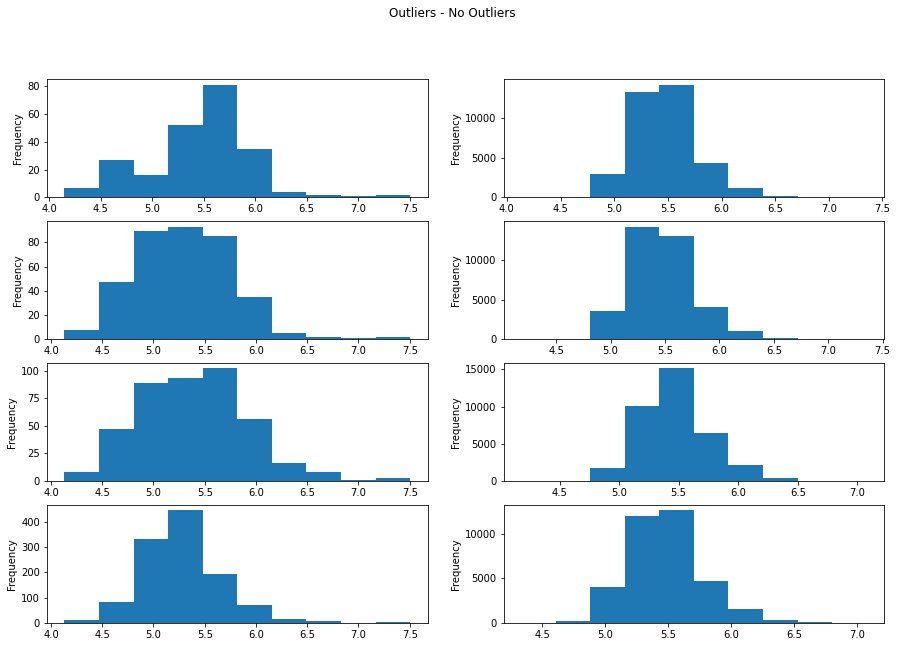

In [5]:
std_permutations = [(4,4), (3,4), (3,3), (2,3)]
census_sale_outs = plot_std(sales, 'census_tract_geoid', 'sale_price_log10', std_permutations)

[(912, 0.003051157064331907), (2534, 0.008477666667781856), (2895, 0.009685416339079902), (10410, 0.034827352017209594)]


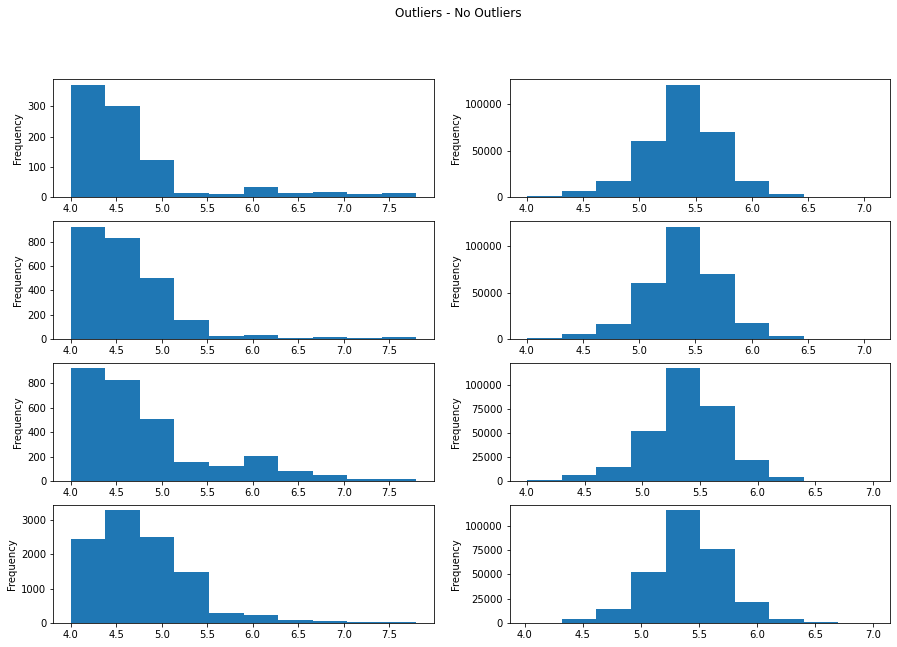

In [6]:
town_sale_outs = plot_std(sales, 'township_code', 'sale_price_log10', std_permutations)

### $ per sqft

In [7]:
sales['price_per_sqft'] = sales['sale_price'] / sales['sqft']
sales['price_per_sqft_log10'] = sales['sale_price_log10'] / sales['sqft']
sales['price_per_sqft'].replace([np.inf, -np.inf], np.nan, inplace=True)
sales['price_per_sqft_log10'].replace([np.inf, -np.inf], np.nan, inplace=True)

/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_

[(384, 0.0017345426950457123), (541, 0.0024437177031763815), (1288, 0.005817945289632494), (3749, 0.016934376468037436)]


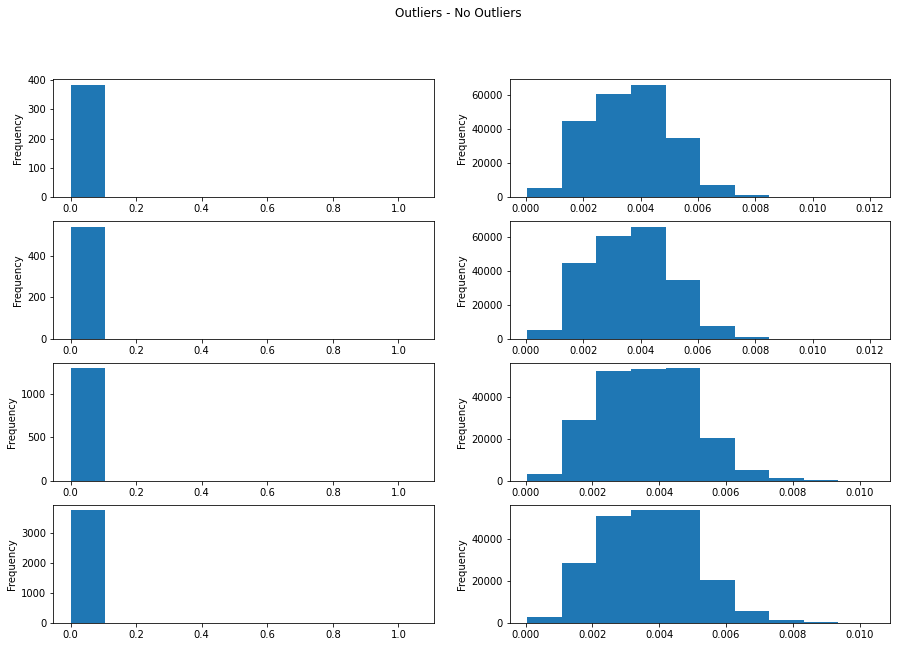

In [8]:
town_sqft_outs = plot_std(sales, 'township_code', 'price_per_sqft_log10', std_permutations)

/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_

[(179, 0.0052395866873518136), (195, 0.0057079296314726455), (270, 0.007903287182039049), (643, 0.018821532066855957)]


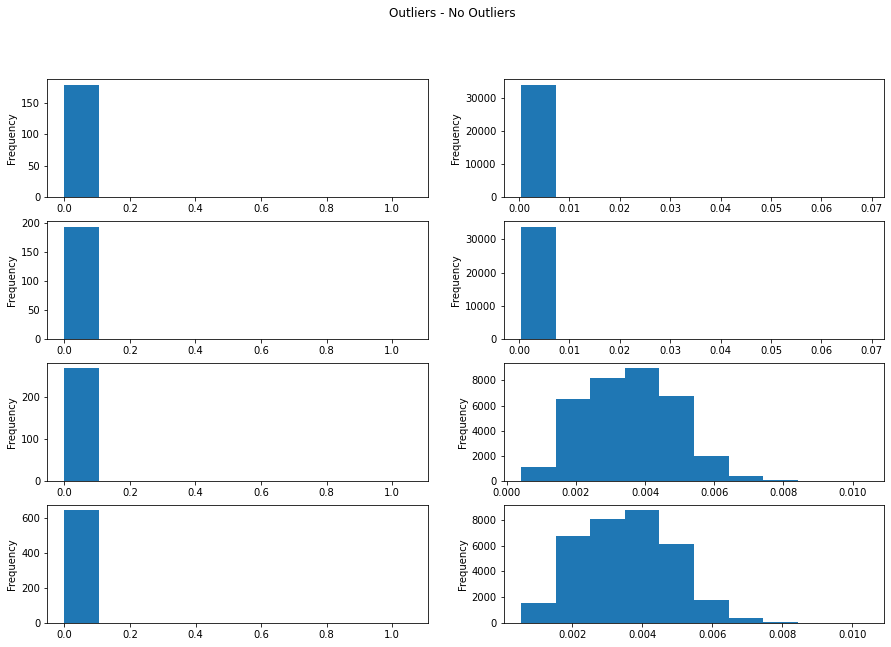

In [9]:
census_sqft_outs = plot_std(sales, 'census_tract_geoid', 'price_per_sqft_log10', std_permutations)

[(912, 0.003051157064331907), (2534, 0.008477666667781856), (2895, 0.009685416339079902), (10410, 0.034827352017209594)]


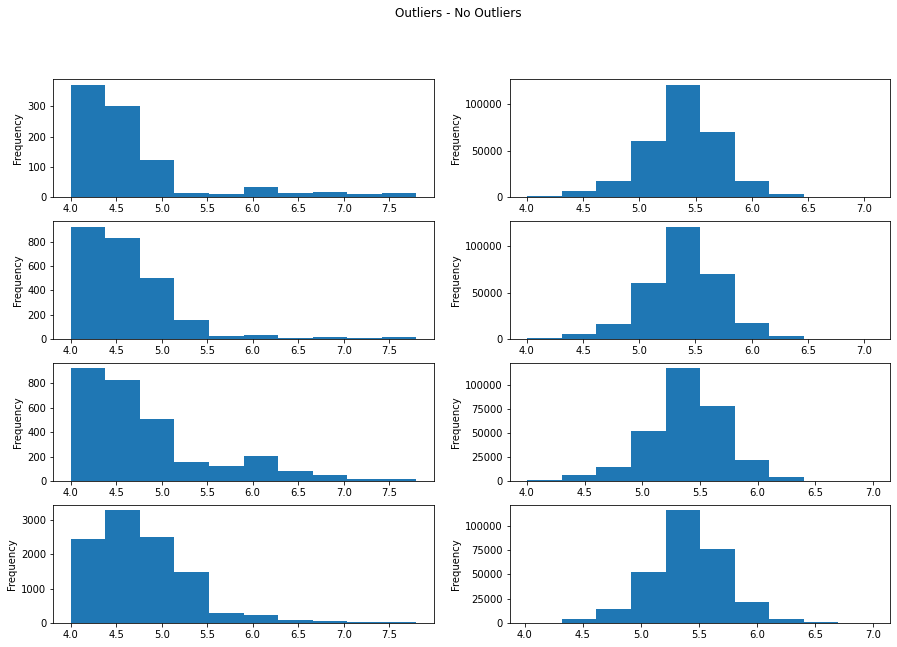

In [10]:
class_outs = plot_std(sales, 'township_code', 'sale_price_log10', std_permutations)

/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_

[(365, 0.0016487189679470964), (467, 0.0021094568713186136), (1136, 0.005131355472843566), (3111, 0.01405250605283128)]


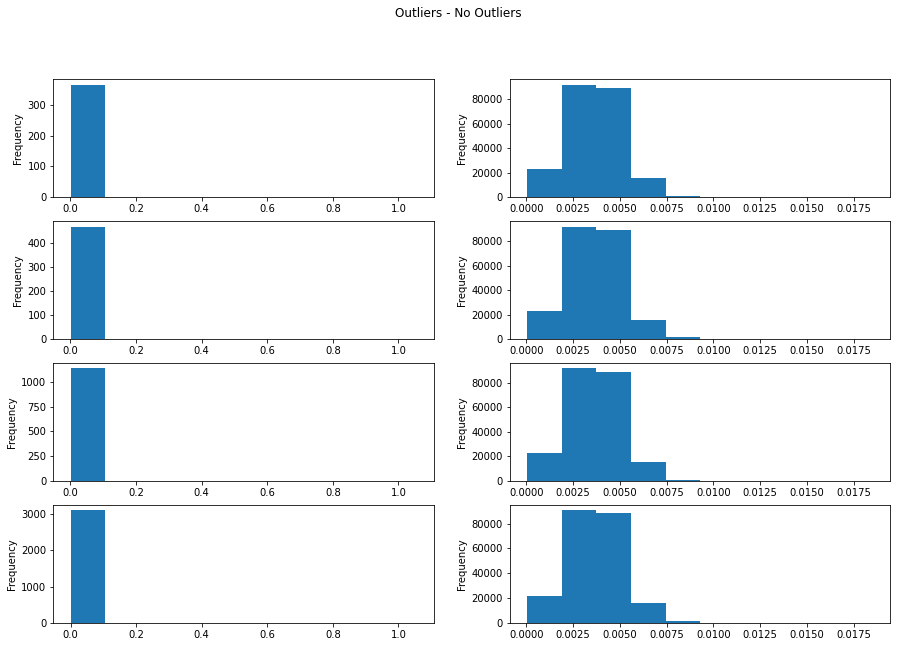

In [11]:
class_outs_sqft = plot_std(sales, 'class', 'price_per_sqft_log10', std_permutations)

#### Overlaps

In [12]:
# Between Township and Census for price
for tup in std_permutations:
    print(tup, len(town_sale_outs[tup]), len(census_sale_outs[tup]), len(pd.merge(town_sale_outs[tup], census_sale_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 912 227 33
(3, 4) 2534 367 113
(3, 3) 2895 423 138
(2, 3) 10410 1165 541


In [13]:
# Between Township and Census for SQFT
for tup in std_permutations:
    print(tup, len(town_sqft_outs[tup]), len(census_sqft_outs[tup]), len(pd.merge(town_sqft_outs[tup], census_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 384 179 5
(3, 4) 541 195 7
(3, 3) 1288 270 36
(2, 3) 3749 643 133


In [14]:
# Within township for price and price/sqft
for tup in std_permutations:
    print(tup, len(town_sale_outs[tup]), len(town_sqft_outs[tup]), len(pd.merge(town_sale_outs[tup], town_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 912 384 20
(3, 4) 2534 541 45
(3, 3) 2895 1288 82
(2, 3) 10410 3749 507


In [15]:
# Within census for price and price/sqft
for tup in std_permutations:
    print(tup, len(census_sale_outs[tup]), len(census_sqft_outs[tup]), len(pd.merge(census_sale_outs[tup], census_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 227 179 160
(3, 4) 367 195 167
(3, 3) 423 270 183
(2, 3) 1165 643 229


# Sale Volatility

Create buckets of which properties fall into which growth rates. Look at absolute value change, see if departing from value of area or moving towards.
See what portion of data illustrates particular outlier flag, and which ones illustrate several outlier flags.

In [50]:
sales['pct'] = sales.sort_values('sale_date').groupby('pin')['sale_price'].pct_change()
township_avg_change = sales.groupby(['township_code'])['pct'].mean()
township_mean = sales.groupby(['township_code'])['sale_price_log10'].mean()
class_mean = sales.groupby(['class'])['sale_price_log10'].mean()


sales.set_index('township_code', inplace=True)
sales['township_avg_change'] = township_avg_change
sales['township_mean_sale_log10'] = township_mean
sales['diff_from_township_mean_sale_log10'] = abs(sales['township_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

sales.set_index('class', inplace=True)
sales['class_mean_sale_log10'] = class_mean
sales['diff_from_class_mean_sale_log10'] = abs(sales['class_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

<AxesSubplot:xlabel='township_mean_sale_log10', ylabel='township_avg_change'>

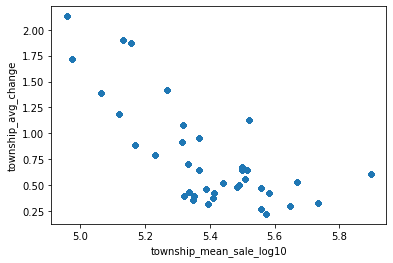

In [51]:
sales.plot.scatter(x='township_mean_sale_log10', y='township_avg_change')

In [52]:
sales[sales['township_code'] == 76]

,class,township_code,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10,class_mean_sale_log10,diff_from_class_mean_sale_log10,days_since_last_transaction
9,211,76.0,16364000080000,2018.0,2018-10-01 00:00:00+00:00,118000.0,5.071882,97299586.0,1831319495,01,...,1888.0,87.797619,0.003774,NaN,0.460942,5.388322,0.316440,5.441753,0.369871,NaN
30,211,76.0,17294270430000,2018.0,2018-02-01 00:00:00+00:00,236000.0,5.372912,97298082.0,1805841021,01,...,1894.0,192.810458,0.004390,0.0,0.460942,5.388322,0.015410,5.441753,0.068841,0.0
31,211,76.0,17294270430000,2018.0,2018-02-01 00:00:00+00:00,236000.0,5.372912,97298082.0,1805841021,01,...,1864.0,168.571429,0.003838,NaN,0.460942,5.388322,0.015410,5.441753,0.068841,NaN
78,203,76.0,17314180080000,2018.0,2018-07-01 00:00:00+00:00,265000.0,5.423246,96705202.0,1820718048,01,...,1888.0,168.253968,0.003443,NaN,0.460942,5.388322,0.034924,5.303952,0.119294,NaN
117,203,76.0,17283180210000,2018.0,2018-08-01 00:00:00+00:00,385000.0,5.585461,97114308.0,1823612060,01,...,1983.0,324.894515,0.004713,NaN,0.460942,5.388322,0.197139,5.303952,0.281508,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298455,299,76.0,17221050501188,2019.0,2019-07-01 00:00:00+00:00,335000.0,5.525045,96591125.0,1919857086,01,...,2008.0,NaN,NaN,NaN,0.460942,5.388322,0.136723,5.317660,0.207385,NaN
298460,299,76.0,17103160331045,2019.0,2019-11-01 00:00:00+00:00,242500.0,5.384712,97481747.0,1932508202,01,...,2001.0,NaN,NaN,NaN,0.460942,5.388322,0.003610,5.317660,0.067052,NaN
298730,203,76.0,17312210040000,2020.0,2020-09-16 00:00:00+00:00,310000.0,5.491362,7098657.0,2032507219,01,...,1893.0,197.075652,0.003491,NaN,0.460942,5.388322,0.103040,5.303952,0.187409,NaN
298757,212,76.0,17282110020000,2018.0,2018-04-01 00:00:00+00:00,570000.0,5.755875,98336720.0,1810318075,01,...,1891.0,186.274510,0.001881,NaN,0.460942,5.388322,0.367553,5.506729,0.249146,NaN


<AxesSubplot:ylabel='Frequency'>

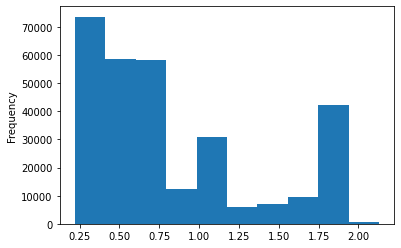

In [53]:
sales.township_avg_change.plot.hist()

## Between transactions for the same property

In [54]:
dups = sales[sales.pin.duplicated(keep=False)]

In [55]:
v_counts = dups.pin.value_counts().reset_index().rename(columns={'index':'pin', 'pin':'counts'})

In [56]:
def is_outlier_column(df: pd.DataFrame, col: str, lower_lim, upper_lim):
    """
    Function that calculates outliers for pandas columns.
    Contrat with is_outlier_groupby().
    """
    lower_limit = df[col].mean() - (df[col].std() * lower_lim)
    upper_limit = df[col].mean() + (df[col].std() * upper_lim)
    return df[~df[col].between(lower_limit, upper_limit)]


In [57]:
count_outliers = {}
for std in std_permutations:
    count_outliers[std] = is_outlier_column(v_counts, 'counts', std[0], std[1])

In [58]:
for tup in std_permutations:
    print(tup, len(count_outliers[tup]))

(4, 4) 182
(3, 4) 182
(3, 3) 182
(2, 3) 182


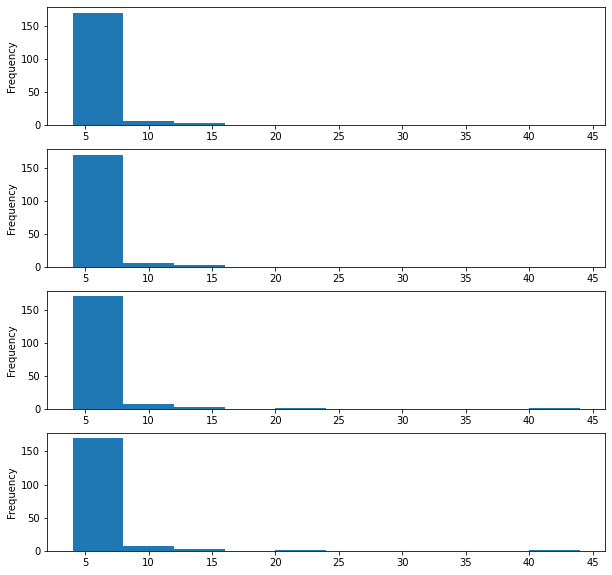

In [59]:
fig, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=len(std_permutations))
for std in range(len(std_permutations)):
    count_outliers[std_permutations[std]].counts.plot.hist(ax=ax[std])

In [60]:
count_outliers[(2,3)]

,pin,counts
0,8121220400000,44
1,17171020430000,20
2,17211330040000,15
3,17341211170000,12
4,17293090360000,12
...,...,...
177,14083040581002,4
178,13152110410000,4
179,20102110380000,4
180,19323210170000,4


/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_

[(300, 0.009014152218983804), (308, 0.00925452961149004), (572, 0.017186983564195787), (588, 0.01766773834920826)]


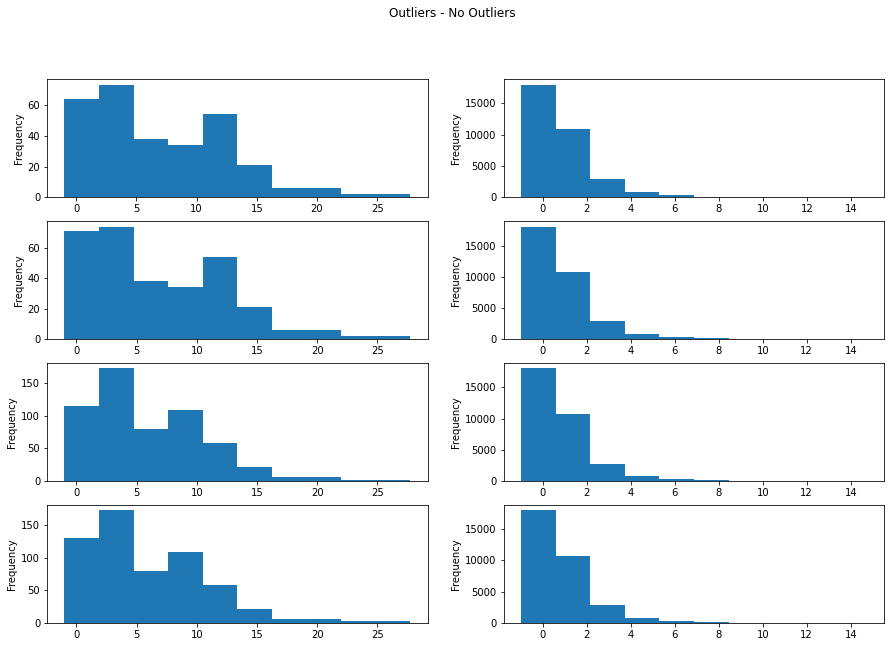

In [61]:
std_permutations = [(4,4), (3,4), (3,3), (2,3)]
volatile_outliers = plot_std(sales, 'township_code', 'pct', std_permutations)

In [62]:
volatile_outliers[(2,3)]

,class,township_code,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10,class_mean_sale_log10,diff_from_class_mean_sale_log10,days_since_last_transaction
149,278,77.0,16032160430000,2021.0,2021-07-19 00:00:00+00:00,397500.0,5.599337,7226615.0,2121725028,01,...,2021.0,187.323280,0.002639,11.421875,1.131973,5.521533,0.077804,5.699926,0.100588,930.0
281,204,77.0,16234180270000,2022.0,2022-02-22 00:00:00+00:00,230000.0,5.361728,7304181.0,2205639015,01,...,1903.0,124.593716,0.002905,6.931034,1.131973,5.521533,0.159805,5.554995,0.193267,1179.0
514,205,72.0,20312250080000,2021.0,2021-10-06 00:00:00+00:00,269900.0,5.431203,7273313.0,2134912090,01,...,1893.0,162.786490,0.003276,7.996667,1.867913,5.158363,0.272840,5.433834,0.002632,828.0
585,211,31.0,15143060120000,2021.0,2021-02-05 00:00:00+00:00,289000.0,5.460898,7153343.0,2106439176,01,...,1920.0,147.148676,0.002780,5.601640,1.081472,5.316818,0.144080,5.441753,0.019145,370.0
967,204,71.0,13292140080000,2020.0,2020-07-01 00:00:00+00:00,325000.0,5.511883,97334007.0,2026212201,05,...,1925.0,158.227848,0.002683,9.156250,0.670836,5.498897,0.012986,5.554995,0.043112,516.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292625,208,19.0,22243060050000,2021.0,2021-11-03 00:00:00+00:00,402000.0,5.604226,7280716.0,2133501110,01,...,1989.0,81.657526,0.001138,0.109731,0.419505,5.581725,0.022501,5.957856,0.353630,1159.0
295256,205,20.0,12254100160000,2021.0,2021-07-20 00:00:00+00:00,625000.0,5.795880,7228673.0,2122134072,05,...,1942.0,347.029428,0.003218,6.352941,0.699796,5.334347,0.461533,5.433834,0.362046,280.0
296752,205,72.0,20284110380000,2021.0,2021-09-20 00:00:00+00:00,285000.0,5.454845,7237409.0,2127342029,01,...,1921.0,141.369048,0.002706,12.013104,1.867913,5.158363,0.296482,5.433834,0.021010,228.0
298831,209,24.0,10343090620000,2020.0,2020-07-01 00:00:00+00:00,1340000.0,6.127105,97333979.0,2026212198,02,...,2019.0,254.028436,0.001162,2.769339,0.476809,5.484434,0.642670,6.171084,0.043979,792.0


## Length of Property Holding

In [63]:
sales['days_since_last_transaction'] = sales.sort_values('sale_date').groupby('pin')['sale_date'].diff().apply(lambda x: x.days)

<AxesSubplot:ylabel='Frequency'>

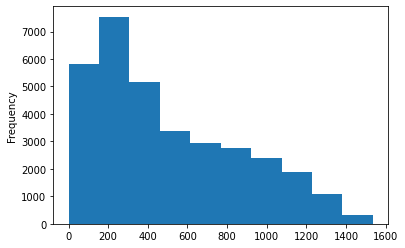

In [64]:
sales.days_since_last_transaction.plot.hist()

In [65]:
sales.days_since_last_transaction.describe()

count    33281.000000
mean       506.714762
std        365.483753
min          0.000000
25%        213.000000
50%        397.000000
75%        775.000000
max       1536.000000
Name: days_since_last_transaction, dtype: float64

/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_

[(53, 0.0015925002253538054), (53, 0.0015925002253538054), (165, 0.0049577837204410925), (203, 0.006099576334845707)]


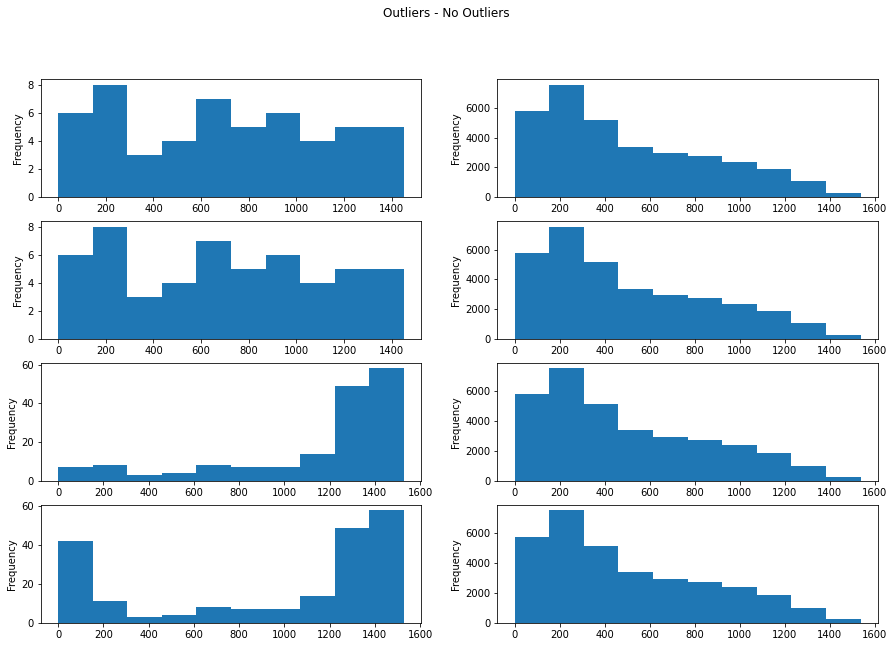

In [66]:
holding_outliers = plot_std(sales, 'township_code', 'days_since_last_transaction', std_permutations)

/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_

[(3, 9.014152218983804e-05), (3, 9.014152218983804e-05), (83, 0.002493915447252186), (83, 0.002493915447252186)]


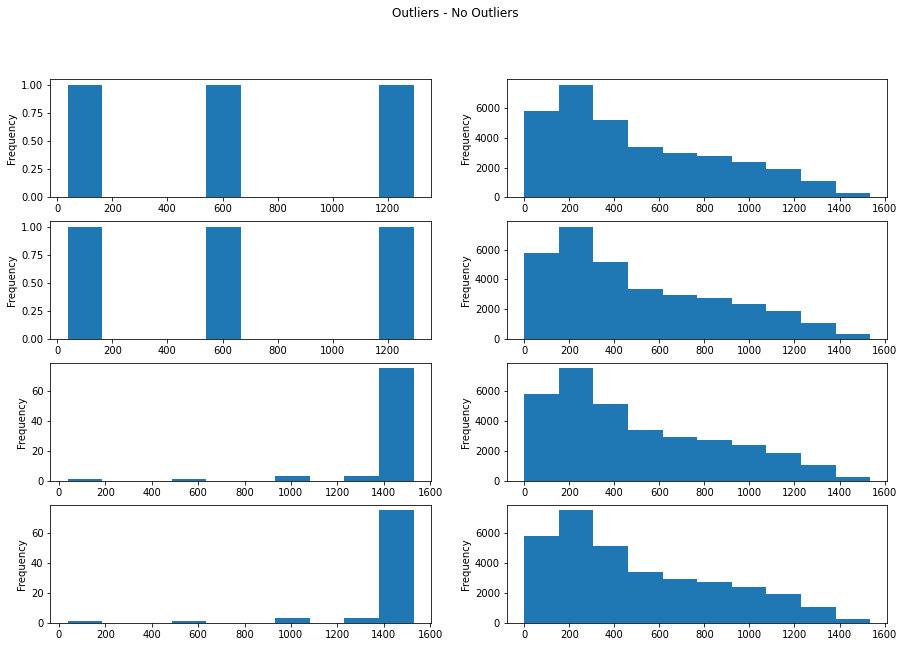

In [67]:
class_holding_outliers = plot_std(sales, 'class', 'days_since_last_transaction', std_permutations)

## Growth Rates

In [68]:
dates = dups.groupby('pin')['sale_date'].agg(['first','last']).reset_index()

In [69]:
firsts = dates[['pin', 'first']].copy()
firsts.rename(columns= {'first': 'sale_date'}, inplace=True)
lasts = dates[['pin', 'last']].copy()
lasts.rename(columns= {'last': 'sale_date'}, inplace=True)

In [70]:
first_transactions = pd.merge(dups, firsts)
last_tranasactions = pd.merge(dups, lasts)

In [71]:
first_transactions[first_transactions.pin == 17293090360000]

,class,township_code,pin,year,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10,class_mean_sale_log10,diff_from_class_mean_sale_log10,days_since_last_transaction
6415,295,76.0,17293090360000,2018.0,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,2008.0,816.151203,0.002697,NaN,0.460942,5.388322,0.890432,5.450357,0.828397,NaN
6416,295,76.0,17293090360000,2018.0,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,2008.0,835.899692,0.002762,0.0,0.460942,5.388322,0.890432,5.450357,0.828397,0.0
6417,295,76.0,17293090360000,2018.0,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,2005.0,816.151203,0.002697,0.0,0.460942,5.388322,0.890432,5.450357,0.828397,0.0
6418,295,76.0,17293090360000,2018.0,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,2005.0,872.359963,0.002883,0.0,0.460942,5.388322,0.890432,5.450357,0.828397,0.0
6419,295,76.0,17293090360000,2018.0,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,2005.0,835.899692,0.002762,0.0,0.460942,5.388322,0.890432,5.450357,0.828397,0.0
6420,295,76.0,17293090360000,2018.0,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,2008.0,872.359963,0.002883,0.0,0.460942,5.388322,0.890432,5.450357,0.828397,0.0


In [72]:
t = last_tranasactions.pin.value_counts()
last_tranasactions = last_tranasactions[last_tranasactions.pin.isin(t.index[~t.gt(1)])]
t = first_transactions.pin.value_counts()
first_transactions = first_transactions[first_transactions.pin.isin(t.index[~t.gt(1)])]

In [73]:
transactions = pd.concat([first_transactions, last_tranasactions], ignore_index=True)

In [74]:
transactions.drop(columns=['pct'], axis=1, inplace=True)
transactions['total_pct'] = transactions.sort_values('sale_date').groupby('pin')['sale_price'].pct_change()
transactions.total_pct.mean()

1.0703044486068327

In [75]:
transactions.total_pct.describe()

count    30455.000000
mean         1.070304
std          1.577306
min         -0.987693
25%          0.145130
50%          0.547128
75%          1.392752
max         27.750000
Name: total_pct, dtype: float64

In [76]:
transactions[transactions.township_code == 76].total_pct.describe()

count    445.000000
mean       0.548682
std        1.054846
min       -0.462963
25%        0.026052
50%        0.155882
75%        0.600000
max       11.235294
Name: total_pct, dtype: float64

In [77]:
"""
transactions = transactions[transactions.pin != 17153040641207]
transactions = transactions[transactions.pin != 17153040641003]
transactions = transactions[transactions.pin != 17153040641141]
transactions = transactions[transactions.pin != 17153040641012]
transactions = transactions[transactions.pin != 17153040641112]
transactions = transactions[transactions.pin != 17153040641195]
transactions = transactions[transactions.pin != 17153040641208]
transactions = transactions[transactions.pin != 17153040641209]
transactions = transactions[transactions.pin != 17153040641010]
transactions = transactions[transactions.pin != 17153040641007]
transactions = transactions[transactions.pin != 17153040641113]
transactions = transactions[transactions.pin != 17153040641135]
transactions = transactions[transactions.pin != 17153040641145]
transactions = transactions[transactions.pin != 17153040641023]
transactions = transactions[transactions.pin != 17153040641062]
transactions = transactions[transactions.pin != 17153040641020]
transactions = transactions[transactions.pin != 17153040641002]
transactions = transactions[transactions.pin != 17153040641144]
transactions = transactions[transactions.pin != 17153040641139]
transactions = transactions[transactions.pin != 17153040641126]
transactions = transactions[transactions.pin != 17153040641074]
transactions = transactions[transactions.pin != 17153040641015]
transactions = transactions[transactions.pin != 17153040641095]
transactions = transactions[transactions.pin != 17153040641125]
transactions = transactions[transactions.pin != 17153040641014]
transactions = transactions[transactions.pin != 17153040641080]
transactions = transactions[transactions.pin != 17153040641089]
transactions = transactions[transactions.pin != 17153040641155]
transactions = transactions[transactions.pin != 17153040641072]
# PINS map to same property

transactions = transactions[transactions.pin != 9154010240000]
transactions = transactions[transactions.pin != 9154010240000]
"""

'\ntransactions = transactions[transactions.pin != 17153040641207]\ntransactions = transactions[transactions.pin != 17153040641003]\ntransactions = transactions[transactions.pin != 17153040641141]\ntransactions = transactions[transactions.pin != 17153040641012]\ntransactions = transactions[transactions.pin != 17153040641112]\ntransactions = transactions[transactions.pin != 17153040641195]\ntransactions = transactions[transactions.pin != 17153040641208]\ntransactions = transactions[transactions.pin != 17153040641209]\ntransactions = transactions[transactions.pin != 17153040641010]\ntransactions = transactions[transactions.pin != 17153040641007]\ntransactions = transactions[transactions.pin != 17153040641113]\ntransactions = transactions[transactions.pin != 17153040641135]\ntransactions = transactions[transactions.pin != 17153040641145]\ntransactions = transactions[transactions.pin != 17153040641023]\ntransactions = transactions[transactions.pin != 17153040641062]\ntransactions = transac

<AxesSubplot:ylabel='Frequency'>

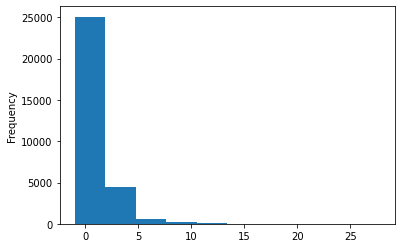

In [78]:
transactions.total_pct.plot.hist()

In [79]:
transactions.groupby('township_code')['total_pct'].mean()

township_code
10.0    0.374418
11.0    1.020474
12.0    1.467673
13.0    0.955112
14.0    2.262407
15.0    1.558235
16.0    0.448555
17.0    0.483216
18.0    0.443711
19.0    0.432998
20.0    0.716877
21.0    0.708175
22.0    0.556339
23.0    0.623903
24.0    0.498016
25.0    0.549473
26.0    0.592302
27.0    0.504758
28.0    0.382529
29.0    0.329384
30.0    0.686520
31.0    1.148819
32.0    1.279650
33.0    0.309286
34.0    0.666732
35.0    0.369694
36.0    1.003759
37.0    1.828558
38.0    0.435760
39.0    0.804520
70.0    2.105898
71.0    0.716096
72.0    2.029013
73.0    0.284184
74.0    0.230078
75.0    0.418401
76.0    0.548682
77.0    1.310667
Name: total_pct, dtype: float64

In [80]:
transactions.groupby('census_tract_geoid')['total_pct'].mean()

census_tract_geoid
1.703180e+10    0.577508
1.703180e+10    0.843546
1.703180e+10    0.383238
1.703180e+10    0.294556
1.703180e+10    0.540205
                  ...   
1.703181e+10    0.313948
1.703181e+10    0.896171
1.703181e+10    0.578984
1.703181e+10    0.251956
1.703181e+10    0.258206
Name: total_pct, Length: 153, dtype: float64

/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_

[(287, 0.009423739944179938), (292, 0.009587916598259727), (531, 0.017435560663273682), (545, 0.017895255294697095)]


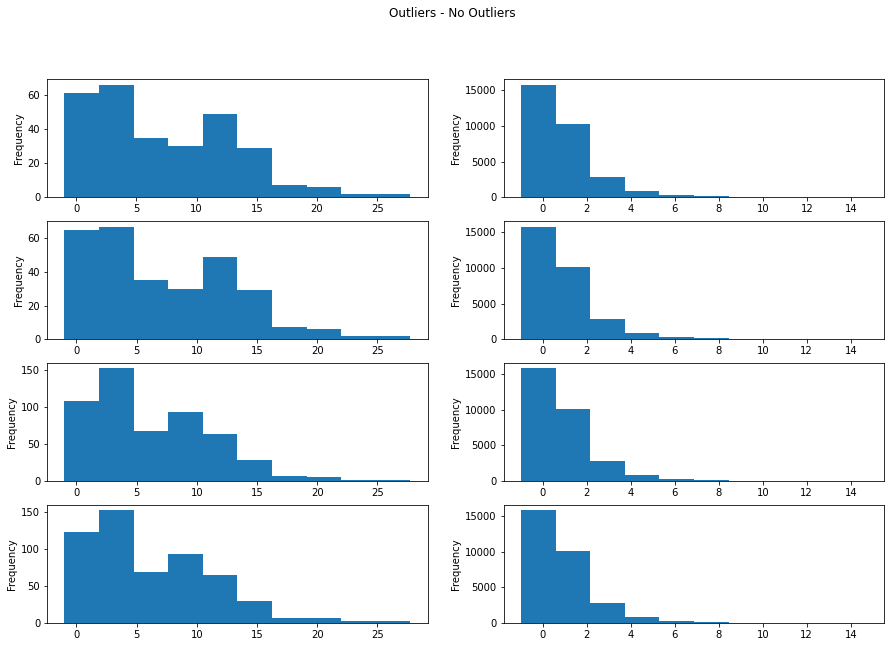

In [81]:
town_growth = plot_std(transactions, 'township_code', 'total_pct', std_permutations)

/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = df.dropna(subset=[group, col])[df.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_698244/2132625190.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = df.dropna(subset=[group, col])[~df.groupby([group, 'class'])[col].apply(is_outlier_

[(274, 0.09651285663966186), (274, 0.09651285663966186), (277, 0.09756956674885522), (278, 0.09792180345191968)]


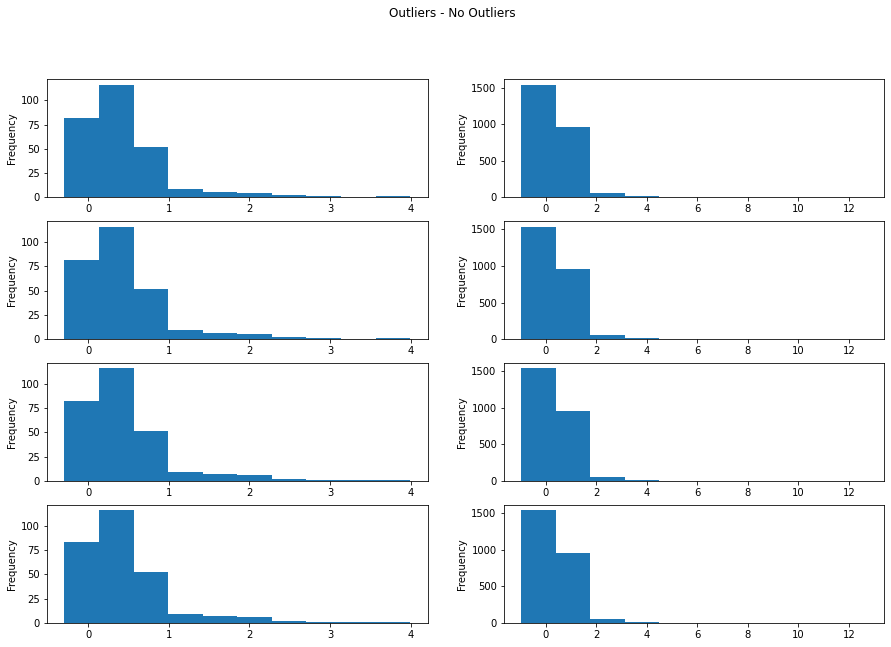

In [82]:
census_growth = plot_std(transactions, 'census_tract_geoid', 'total_pct', std_permutations)

## Moving Towards/Away From Mean

In [84]:
dups.diff_from_class_mean_sale_log10

5         0.344408
6         0.067116
12        0.036627
13        0.078825
20        0.540073
            ...   
298740    0.083292
298741    0.083292
298831    0.043979
298842    0.374424
298895    0.567863
Name: diff_from_class_mean_sale_log10, Length: 64150, dtype: float64

In [85]:
temp = dups.sort_values('sale_date').groupby(['pin'])['diff_from_township_mean_sale_log10'].shift()
dups['town_movement'] = dups['diff_from_township_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards


temp = dups.sort_values('sale_date').groupby(['pin'])['diff_from_class_mean_sale_log10'].shift()
dups['class_movement'] = dups['diff_from_class_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards

/tmp/ipykernel_698244/1202430475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups['town_movement'] = dups['diff_from_township_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards
/tmp/ipykernel_698244/1202430475.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups['class_movement'] = dups['diff_from_class_mean_sale_log10'].lt(temp).astype(float) # 0 is moving away, 1 is moving towards


In [86]:
dups.town_movement.value_counts()

0.0    46326
1.0    17824
Name: town_movement, dtype: int64

In [87]:
dups.class_movement.value_counts()

0.0    45040
1.0    19110
Name: class_movement, dtype: int64